Reduced MNIST Tutorial : take a pre-trained network and fine-tune it on new classification task

THALES DMS France, 2019, Atelier ALLOHA du 15/01/2019

Import lib

In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Activation, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Input
from keras import applications
from keras.applications.vgg16 import preprocess_input
from keras import backend as K
from keras import optimizers
from keras.datasets import mnist
from keras.utils import to_categorical
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

/home/user/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Database

In [2]:
# load mnist data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# reduce dataset size
n_train, img_height, img_width = x_train.shape
n_train = 400
x_train.shape
x_train = x_train[:n_train,:,:]
y_train = y_train[:n_train]
n_test = 800
x_test = x_test[:n_test,:,:]
y_test = y_test[:n_test]

num_classes = np.max(y_train)+1
y_train_class = to_categorical(y_train,num_classes=num_classes)
y_test_class = to_categorical(y_test,num_classes=num_classes)

# resize images
img_width, img_height = 48, 48
x_train_r = np.zeros((n_train, img_height, img_width))
x_test_r = np.zeros((n_test, img_height, img_width))
for row in range(n_train):
    x_train_r[row,:,:] = np.array(Image.fromarray(x_train[row,:,:]).resize((img_height,img_width),Image.ANTIALIAS))
for row in range(n_test):
    x_test_r[row,:,:] = np.array(Image.fromarray(x_test[row,:,:]).resize((img_height,img_width),Image.ANTIALIAS))

# duplicate on 3 channels
x_train = np.zeros((n_train, img_height, img_width, 3))
x_test = np.zeros((n_test, img_height, img_width, 3))
x_train[:,:,:,0] = x_train_r/1.0
x_train[:,:,:,1] = x_train_r/1.0
x_train[:,:,:,2] = x_train_r/1.0
x_test[:,:,:,0] = x_test_r/1.0
x_test[:,:,:,1] = x_test_r/1.0
x_test[:,:,:,2] = x_test_r/1.0
    
x_train.shape, x_test.shape

((400, 48, 48, 3), (800, 48, 48, 3))

Images dimensions

In [3]:
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

Training parameters

In [4]:
epochs = 20
batch_size = 16
top_model_weights_path = 'bottleneck_fc_model.h5'

Load VGG16 without fully-connected layers

In [5]:
input_tensor = Input(shape=input_shape)
base_model = applications.VGG16(weights='imagenet', include_top=False, input_tensor=input_tensor)
print('VGG16 Model loaded.')

VGG16 Model loaded.


Add a dense neural network on top

In [6]:
top_model = Sequential()
top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
top_model.add(Dense(64, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(num_classes))
top_model.add(Activation('softmax'))
# It is recommended to start with a fully-trained classifier, including the top classifier,
# in order to successfully do fine-tuning
top_model.load_weights(top_model_weights_path)

model = Model(inputs=base_model.input, outputs=top_model(base_model.output))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0         
__________

Set the first 15 layers (up to the last conv block) to non-trainable (weights will not be updated)

In [7]:
for layer in model.layers[:15]:
    layer.trainable = False

Compile the model with a SGD/momentum optimizer and a very slow learning rate.

In [8]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=1e-6, momentum=0.9),
              metrics=['accuracy'])

Data

In [9]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    width_shift_range=0.025,
    height_shift_range=0.025,
    rotation_range=10,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow(
        x_train,
        y_train_class,
        batch_size=batch_size,
        shuffle=False)

validation_generator = test_datagen.flow(
        x_test,
        y_test_class,
        batch_size=batch_size,
        shuffle=False)

Fine-tune the model

In [10]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=n_train//batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=n_test//batch_size)

Epoch 1/20
25/25 [==============================] - 12s 489ms/step - loss: 0.8195 - acc: 0.8150 - val_loss: 0.9825 - val_acc: 0.8150
Epoch 2/20
25/25 [==============================] - 12s 470ms/step - loss: 0.7767 - acc: 0.8300 - val_loss: 0.9591 - val_acc: 0.8100
Epoch 3/20
25/25 [==============================] - 12s 470ms/step - loss: 0.9947 - acc: 0.7800 - val_loss: 0.8520 - val_acc: 0.8263
Epoch 4/20
25/25 [==============================] - 12s 472ms/step - loss: 0.5648 - acc: 0.8350 - val_loss: 0.8260 - val_acc: 0.8275
Epoch 5/20
25/25 [==============================] - 12s 470ms/step - loss: 0.7279 - acc: 0.8425 - val_loss: 0.8332 - val_acc: 0.8313
Epoch 6/20
25/25 [==============================] - 12s 476ms/step - loss: 0.6437 - acc: 0.8600 - val_loss: 0.8657 - val_acc: 0.8287
Epoch 7/20
25/25 [==============================] - 13s 503ms/step - loss: 0.6042 - acc: 0.8175 - val_loss: 0.8363 - val_acc: 0.8363
Epoch 8/20
25/25 [==============================] - 12s 479ms/step - 

Plot

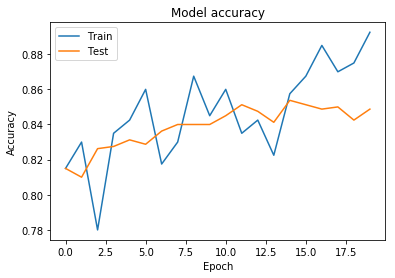

In [11]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

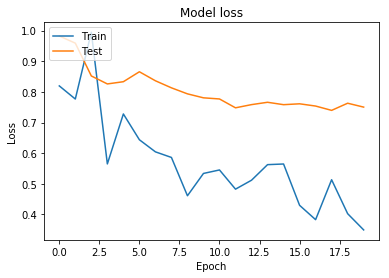

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()